## Part 1: Data Preprocessing

In [1]:
import os
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import re
from typing import List

### 1.1 Downloading

In [2]:
def get_parquet_links(url: str, keyword: str, start_date: str = "2020-01", end_date: str = "2024-08") -> List[str]:
    """
    Fetch all Parquet file links from a webpage that match the specified keyword 
    and fall within the given date range (YYYY-MM format).
    """
    start_dt = datetime.strptime(start_date, "%Y-%m")
    end_dt = datetime.strptime(end_date, "%Y-%m")

    response = requests.get(url)  
    soup = BeautifulSoup(response.text, "html.parser")
    links = soup.find_all("a", href=True)  # Find all <a> tags with href attribute
    parquet_links = []

    for link in links:
        href = link['href'].strip() #Remove extra spaces around href
        # Check if the link contains the keyword and ends with .parquet
        if keyword in href and href.endswith('.parquet'):
            # Extract the date in YYYY-MM format from the file name
            date_match = re.search(r'(\d{4}-\d{2})', href)
            if date_match:
                file_date = datetime.strptime(date_match.group(1), "%Y-%m")
                # Check if the file date falls within the specified range
                if start_dt <= file_date <= end_dt:
                    parquet_links.append(href)
    return parquet_links


In [3]:
# Function to download the Parquet files from the provided links to the specified directory
def download_parquet_files(parquet_links: List[str], download_directory: str) -> None:
    for idx, file_url in enumerate(parquet_links):
        # Generate the complete path for the file
        file_name = file_url.split("/")[-1]
        file_path = os.path.join(download_directory, file_name)
        # If the file already exists, skip the download
        if os.path.exists(file_path):
            print(f"File {file_name} already downloaded, skipping.")
            continue
        # Download the file
        response = requests.get(file_url, stream=True)
        if response.status_code == 200:
            with open(file_path, "wb") as f:
                f.write(response.content)
            print(f"Downloaded {file_name} successfully.")

# Main function to download Parquet data
def download_parquet_data(url: str, keyword: str, download_directory: str) -> None:
    # Get the links for Parquet files containing the keyword
    parquet_links = get_parquet_links(url, keyword,start_date="2020-01", end_date="2024-08")
    if parquet_links:
        # Download the files that are not already present in the directory
        download_parquet_files(parquet_links, download_directory)
    else:
        print(f"No matching Parquet files found for keyword: {keyword}")

In [4]:
url = "https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page"  

# Download "Yellow Taxi" data
keyword_yellow_taxi = "yellow"
download_directory_yellow_taxi = r"E:\2024 Fall Academic\Tools for Analytics\Project\Yellow Taxi"  # Folder to store downloaded files
download_parquet_data(url, keyword_yellow_taxi, download_directory_yellow_taxi)


# Download "High Volume For-Hire Vehicle" data
keyword_hvfhv = "fhvhv"
download_directory_hvfhv = r"E:\2024 Fall Academic\Tools for Analytics\Project\HVFHV"  # Folder to store downloaded files
download_parquet_data(url, keyword_hvfhv, download_directory_hvfhv)


File yellow_tripdata_2024-01.parquet already downloaded, skipping.
File yellow_tripdata_2024-02.parquet already downloaded, skipping.
File yellow_tripdata_2024-03.parquet already downloaded, skipping.
File yellow_tripdata_2024-04.parquet already downloaded, skipping.
File yellow_tripdata_2024-05.parquet already downloaded, skipping.
File yellow_tripdata_2024-06.parquet already downloaded, skipping.
File yellow_tripdata_2024-07.parquet already downloaded, skipping.
File yellow_tripdata_2024-08.parquet already downloaded, skipping.
File yellow_tripdata_2023-01.parquet already downloaded, skipping.
File yellow_tripdata_2023-02.parquet already downloaded, skipping.
File yellow_tripdata_2023-03.parquet already downloaded, skipping.
File yellow_tripdata_2023-04.parquet already downloaded, skipping.
File yellow_tripdata_2023-05.parquet already downloaded, skipping.
File yellow_tripdata_2023-06.parquet already downloaded, skipping.
File yellow_tripdata_2023-07.parquet already downloaded, skipp

### 1.2 Data Sampling

In [5]:
import os
import numpy as np
import pandas as pd

In [6]:
# Function to calculate the sample size using Cochran's formula
def calculate_sample_size(population_size: int, e: float = 0.05, p: float = 0.5) -> int:
    Z = 1.96  # Z value for 95% confidence level
    numerator = Z**2 * p * (1 - p)
    denominator = e**2 * (population_size - 1) + Z**2 * p * (1 - p)
    sample_size = (numerator / denominator) * population_size
    return int(np.ceil(sample_size))  # Round up to ensure enough sample size

In [7]:
# Function to perform sampling for each Parquet file
def sample_parquet_file(file_path: str, output_directory: str) -> None:
    # Read the Parquet file into a DataFrame
    df = pd.read_parquet(file_path)
    
    # Get the population size (total number of rows in the file)
    population_size = len(df)
    
    # Calculate the required sample size
    sample_size = calculate_sample_size(population_size)
    print(f"File: {file_path} - Total records: {population_size}, Sample size: {sample_size}")
    
    # Perform random sampling
    sampled_data = df.sample(n=sample_size, random_state=40)
    
    # Save the sampled data to a new file in the output directory
    file_name = os.path.basename(file_path)
    sampled_file_path = os.path.join(output_directory, f"sampled_{file_name}")
    sampled_data.to_parquet(sampled_file_path, compression='snappy')
    print(f"Sampled data saved to: {sampled_file_path}")

In [8]:
# Main function to sample all Parquet files in a directory
def sample_all_parquet_files(input_directory: str, output_directory: str) -> None:    
    # Loop through each file in the input directory
    for file_name in os.listdir(input_directory):
        file_path = os.path.join(input_directory, file_name)
        
        # If the file is already in the output directory, skip the sampling
        if os.path.exists(os.path.join(output_directory, f"sampled_{file_name}")):
            print(f"File {file_name} already sampled, skipping.")
            continue
        
        # Check if the file is a Parquet file
        if file_name.endswith('.parquet'):
            # Sample the Parquet file and save the result
            sample_parquet_file(file_path, output_directory)

In [9]:
def merge_sampled_parquet_files(input_directory: str) -> pd.DataFrame:
    dataframes = []
    # Iterate over all files in the input directory
    for file_name in os.listdir(input_directory):
        if file_name.endswith('.parquet'):  # Process only Parquet files
            file_path = os.path.join(input_directory, file_name)
            print(f"Reading file: {file_path}")
            # Read the Parquet file into a DataFrame
            df = pd.read_parquet(file_path)
            # Append the DataFrame to the list
            dataframes.append(df)
    # Concatenate all DataFrames in the list
    combined_dataframe = pd.concat(dataframes, ignore_index=True)
    print(f"Successfully merged {len(dataframes)} files into a single DataFrame.")
    return combined_dataframe

#### 1.2.1 Sampling yellow taxi data

In [10]:
input_directory = "E:/2024 Fall Academic/Tools for Analytics/Project/Yellow Taxi"  
output_directory = "E:/2024 Fall Academic/Tools for Analytics/Project/Yellow Taxi Sample" 

# Perform sampling on all Parquet files in the input directory
sample_all_parquet_files(input_directory, output_directory)
# Merge all sampled Parquet files into a single DataFrame
yellow_taxi_df = merge_sampled_parquet_files(output_directory)

yellow_taxi_df=yellow_taxi_df.dropna(axis=1, how="all")
yellow_taxi_df

File yellow_tripdata_2020-01.parquet already sampled, skipping.
File yellow_tripdata_2020-02.parquet already sampled, skipping.
File yellow_tripdata_2020-03.parquet already sampled, skipping.
File yellow_tripdata_2020-04.parquet already sampled, skipping.
File yellow_tripdata_2020-05.parquet already sampled, skipping.
File yellow_tripdata_2020-06.parquet already sampled, skipping.
File yellow_tripdata_2020-07.parquet already sampled, skipping.
File yellow_tripdata_2020-08.parquet already sampled, skipping.
File yellow_tripdata_2020-09.parquet already sampled, skipping.
File yellow_tripdata_2020-10.parquet already sampled, skipping.
File yellow_tripdata_2020-11.parquet already sampled, skipping.
File yellow_tripdata_2020-12.parquet already sampled, skipping.
File yellow_tripdata_2021-01.parquet already sampled, skipping.
File yellow_tripdata_2021-02.parquet already sampled, skipping.
File yellow_tripdata_2021-03.parquet already sampled, skipping.
File yellow_tripdata_2021-04.parquet alr

C:\Users\perki\AppData\Local\Temp\ipykernel_34324\1081269227.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_dataframe = pd.concat(dataframes, ignore_index=True)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,Airport_fee
0,2,2020-01-21 18:56:18,2020-01-21 19:08:41,1.0,2.27,1.0,N,170,141,1,10.0,1.0,0.5,1.70,0.00,0.3,16.00,2.5,NaN,NaN
1,2,2020-01-20 15:55:43,2020-01-20 16:00:45,2.0,0.87,1.0,N,164,170,1,5.5,0.0,0.5,1.00,0.00,0.3,9.80,2.5,NaN,NaN
2,2,2020-01-22 20:05:14,2020-01-22 20:13:53,1.0,0.76,1.0,N,162,229,1,7.0,0.5,0.5,2.16,0.00,0.3,12.96,2.5,NaN,NaN
3,1,2020-01-22 07:04:51,2020-01-22 07:54:32,1.0,0.00,1.0,N,159,89,1,46.2,0.0,0.5,0.00,6.12,0.3,53.12,0.0,NaN,NaN
4,2,2020-01-22 06:58:21,2020-01-22 07:01:47,2.0,0.75,1.0,N,100,50,1,4.5,0.0,0.5,1.95,0.00,0.3,9.75,2.5,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21551,2,2024-08-08 22:16:46,2024-08-08 22:31:47,2.0,2.37,1.0,N,68,163,2,15.6,1.0,0.5,0.00,0.00,1.0,20.60,2.5,NaN,0.00
21552,2,2024-08-24 18:53:23,2024-08-24 19:11:06,1.0,8.12,1.0,N,138,263,1,32.4,5.0,0.5,0.00,6.94,1.0,50.09,2.5,NaN,1.75
21553,2,2024-08-18 18:21:03,2024-08-18 18:37:13,1.0,1.86,1.0,N,170,90,1,14.9,0.0,0.5,3.78,0.00,1.0,22.68,2.5,NaN,0.00
21554,2,2024-08-15 06:34:03,2024-08-15 06:42:49,2.0,1.64,1.0,N,161,239,1,11.4,0.0,0.5,3.08,0.00,1.0,18.48,2.5,NaN,0.00


In [11]:
filepath = r"E:/2024 Fall Academic/Tools for Analytics/Project/yellow_taxi_sampled.csv"
if not os.path.exists(filepath):
    # If it doesn't exist, save the dataframe to the file
    yellow_taxi_df.to_csv(filepath, index=False)
    print("File saved successfully.")
else:
    print("File already exists. Skipping save.")

File already exists. Skipping save.


#### 1.2.2 Sampling Uber data

In [12]:
input_directory = "E:/2024 Fall Academic/Tools for Analytics/Project/HVFHV"  # Folder containing original Parquet files
output_directory = "E:/2024 Fall Academic/Tools for Analytics/Project/HVFHV Sample"  # Folder to save the sampled Parquet files

# Perform sampling on all Parquet files in the input directory
sample_all_parquet_files(input_directory, output_directory)
# Merge all sampled Parquet files into a single DataFrame
HVFHV_df = merge_sampled_parquet_files(output_directory)

HVFHV_df=HVFHV_df.dropna(axis=1, how="all")
HVFHV_df

File fhvhv_tripdata_2020-01.parquet already sampled, skipping.
File fhvhv_tripdata_2020-02.parquet already sampled, skipping.
File fhvhv_tripdata_2020-03.parquet already sampled, skipping.
File fhvhv_tripdata_2020-04.parquet already sampled, skipping.
File fhvhv_tripdata_2020-05.parquet already sampled, skipping.
File fhvhv_tripdata_2020-06.parquet already sampled, skipping.
File fhvhv_tripdata_2020-07.parquet already sampled, skipping.
File fhvhv_tripdata_2020-08.parquet already sampled, skipping.
File fhvhv_tripdata_2020-09.parquet already sampled, skipping.
File fhvhv_tripdata_2020-10.parquet already sampled, skipping.
File fhvhv_tripdata_2020-11.parquet already sampled, skipping.
File fhvhv_tripdata_2020-12.parquet already sampled, skipping.
File fhvhv_tripdata_2021-01.parquet already sampled, skipping.
File fhvhv_tripdata_2021-02.parquet already sampled, skipping.
File fhvhv_tripdata_2021-03.parquet already sampled, skipping.
File fhvhv_tripdata_2021-04.parquet already sampled, sk

C:\Users\perki\AppData\Local\Temp\ipykernel_34324\1081269227.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_dataframe = pd.concat(dataframes, ignore_index=True)


,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0003,B02872,B02872,2020-01-25 06:32:19,2020-01-25 06:38:11,2020-01-25 06:38:42,2020-01-25 06:44:40,32,18,1.860,...,0.50,0.00,NaN,0.00,5.39,Y,N,,N,N
1,HV0005,B02510,None,2020-01-23 01:44:51,NaT,2020-01-23 01:49:21,2020-01-23 02:12:36,88,7,9.211,...,2.61,2.75,NaN,0.00,21.60,N,N,N,N,N
2,HV0003,B02872,B02872,2020-01-06 18:16:36,2020-01-06 18:16:51,2020-01-06 18:19:01,2020-01-06 18:29:42,92,53,2.090,...,0.59,0.00,NaN,0.00,7.57,N,N,,N,N
3,HV0003,B02872,B02872,2020-01-22 21:25:56,2020-01-22 21:28:29,2020-01-22 21:29:23,2020-01-22 21:38:26,161,50,1.520,...,0.77,2.75,NaN,0.00,6.14,N,N,,N,N
4,HV0005,B02510,None,2020-01-24 17:02:22,NaT,2020-01-24 17:05:01,2020-01-24 17:10:08,132,132,2.289,...,0.88,0.00,NaN,5.00,5.39,N,N,N,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21555,HV0003,B03404,B03404,2024-08-14 19:46:30,2024-08-14 19:51:21,2024-08-14 19:53:23,2024-08-14 20:09:17,188,181,2.370,...,1.57,0.00,0.0,0.00,12.49,N,N,N,N,N
21556,HV0003,B03404,B03404,2024-08-06 21:14:28,2024-08-06 21:22:51,2024-08-06 21:23:07,2024-08-06 21:37:52,158,13,2.610,...,3.35,2.75,0.0,4.49,20.40,N,N,N,N,N
21557,HV0003,B03404,B03404,2024-08-17 13:26:17,2024-08-17 13:27:41,2024-08-17 13:28:59,2024-08-17 13:46:35,82,157,2.640,...,1.58,0.00,0.0,0.00,13.85,N,N,N,N,N
21558,HV0005,B03406,None,2024-08-31 11:57:25,NaT,2024-08-31 12:21:53,2024-08-31 12:37:53,238,262,2.275,...,2.06,2.75,0.0,4.29,19.20,N,N,N,N,N


In [13]:
filepath = r"E:/2024 Fall Academic/Tools for Analytics/Project/HVFHV_sampled.csv"
if not os.path.exists(filepath):
    # If it doesn't exist, save the dataframe to the file
    HVFHV_df.to_csv(filepath, index=False)
    print("File saved successfully.")
else:
    print("File already exists. Skipping save.")


File already exists. Skipping save.


### 1.3 Cleaning & filtering

In [14]:
import pandas as pd
import numpy as np
import requests
import geopandas as gpd
from bs4 import BeautifulSoup
import re
import math
import zipfile
import os

#### 1.3.1 Loading yellow taxi and hvfhv data

In [15]:
sampled_data_yellow_taxi = yellow_taxi_df
sampled_data_HVFHV = HVFHV_df

#### 1.3.2 Loading taxi zones data

In [16]:
url = "https://d37ci6vzurychx.cloudfront.net/misc/taxi_zones.zip"
local_zip = "taxi_zones.zip"

# Download the ZIP file
response = requests.get(url, stream=True)
with open(local_zip, "wb") as f:
    f.write(response.content)

# Extract the ZIP file
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall("taxi_zones")

# Path to the extracted shapefile
shapefile_path = "taxi_zones/taxi_zones.shp"

zones = gpd.read_file("taxi_zones/taxi_zones.shp")


# Reproject to WGS84 (latitude/longitude coordinate system)
if zones.crs is not None and zones.crs.to_string() != "EPSG:4326":
    zones = zones.to_crs(epsg=4326)

# Calculate the center of each zone
zones["zone_center"] = zones.geometry.centroid
zones["latitude"] = zones["zone_center"].y
zones["longitude"] = zones["zone_center"].x

# Extract only necessary columns
zone_centers = zones[["LocationID", "latitude", "longitude"]]

# Check the results
zone_centers.head()

C:\Users\perki\AppData\Local\Temp\ipykernel_34324\2223963518.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zones["zone_center"] = zones.geometry.centroid


,LocationID,latitude,longitude
0,1,40.691831,-74.174000
1,2,40.616745,-73.831299
2,3,40.864473,-73.847422
3,4,40.723752,-73.976968
4,5,40.552659,-74.188485


#### 1.3.3 Cleaning yellow taxi data

In [17]:
from pandas import DataFrame
def clean_yellow_taxi_data(df: DataFrame, zone_centers: DataFrame) -> DataFrame:
    """
    Cleans and filters the Yellow Taxi dataset.
    
    Parameters:
        df (pd.DataFrame): The Yellow Taxi dataset to clean.
        zone_centers (pd.DataFrame): DataFrame containing LocationID, latitude, and longitude.
        
    Returns:
        pd.DataFrame: Cleaned and filtered dataset.
    """
    # Merge pickup and dropoff zones to get latitude and longitude
    df = df.merge(zone_centers, how="left", left_on="PULocationID", right_on="LocationID")
    df.rename(columns={"latitude": "pickup_latitude", "longitude": "pickup_longitude"}, inplace=True)
    df.drop(columns=["LocationID"], inplace=True)

    df = df.merge(zone_centers, how="left", left_on="DOLocationID", right_on="LocationID")
    df.rename(columns={"latitude": "dropoff_latitude", "longitude": "dropoff_longitude"}, inplace=True)
    df.drop(columns=["LocationID"], inplace=True)

    # Drop rows where coordinates couldn't be determined
    df = df.dropna(subset=["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"])

    # Remove rows with invalid trip distance or total amount
    df = df[(df["trip_distance"] >= 0) & (df["total_amount"] > 0)]

    # Ensure passenger_count is valid (non-negative integers)
    df["passenger_count"] = pd.to_numeric(df["passenger_count"], errors="coerce").fillna(0).astype(int)
    df = df[df["passenger_count"] >= 0]

    # Filter trips within valid latitude/longitude bounding box
    LAT_MIN, LAT_MAX = 40.560445, 40.908524
    LON_MIN, LON_MAX = -74.242330, -73.717047
    df = df[
        (df["pickup_latitude"].between(LAT_MIN, LAT_MAX)) &
        (df["pickup_longitude"].between(LON_MIN, LON_MAX)) &
        (df["dropoff_latitude"].between(LAT_MIN, LAT_MAX)) &
        (df["dropoff_longitude"].between(LON_MIN, LON_MAX))
    ]

    # Normalize column names to lowercase
    df.columns = df.columns.str.lower()

    # Ensure datetime columns are in the correct format
    df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"], errors="coerce")
    df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"], errors="coerce")

    # Drop invalid datetime rows
    df = df.dropna(subset=["tpep_pickup_datetime", "tpep_dropoff_datetime"])

    # Remove unnecessary columns and keep relevant ones
    columns_to_keep = [
        "tpep_pickup_datetime", "tpep_dropoff_datetime",  # Times
        "passenger_count", "trip_distance",              # Trip details
        "fare_amount", "total_amount", "tip_amount",     # Payment info
        "ratecodeid", "store_and_fwd_flag",              # Taxi-specific info
        "pickup_latitude", "pickup_longitude",           # Pickup coordinates
        "dropoff_latitude", "dropoff_longitude",
        "mta_tax", "tolls_amount", 
        "congestion_surcharge"
    ]
    df = df[columns_to_keep]


    return df


# Clean Yellow Taxi data
print("Cleaning Yellow Taxi data...")
cleaned_yellow_taxi = clean_yellow_taxi_data(sampled_data_yellow_taxi, zone_centers)

# Save cleaned Yellow Taxi data
cleaned_yellow_taxi.to_parquet("yellow_taxi_cleaned.parquet")
print("Cleaned Yellow Taxi data saved: yellow_taxi_cleaned.parquet")

cleaned_yellow_taxi.head()
cleaned_yellow_taxi.info()
cleaned_yellow_taxi.describe()

Cleaning Yellow Taxi data...
Cleaned Yellow Taxi data saved: yellow_taxi_cleaned.parquet
<class 'pandas.core.frame.DataFrame'>
Index: 21049 entries, 0 to 21559
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tpep_pickup_datetime   21049 non-null  datetime64[us]
 1   tpep_dropoff_datetime  21049 non-null  datetime64[us]
 2   passenger_count        21049 non-null  int32         
 3   trip_distance          21049 non-null  float64       
 4   fare_amount            21049 non-null  float64       
 5   total_amount           21049 non-null  float64       
 6   tip_amount             21049 non-null  float64       
 7   ratecodeid             19893 non-null  float64       
 8   store_and_fwd_flag     19893 non-null  object        
 9   pickup_latitude        21049 non-null  float64       
 10  pickup_longitude       21049 non-null  float64       
 11  dropoff_latitude       21049 non-nu

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount,tip_amount,ratecodeid,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,mta_tax,tolls_amount,congestion_surcharge
count,21049,21049,21049.000000,21049.000000,21049.000000,21049.000000,21049.000000,19893.000000,21049.000000,21049.000000,21049.000000,21049.000000,21049.000000,21049.000000,19893.000000
mean,2022-04-30 07:06:19.554705,2022-04-30 07:22:25.957432,1.337308,3.175365,15.361859,22.396931,2.654193,1.450862,40.753791,-73.967146,40.755399,-73.970248,0.497022,0.420866,2.311366
min,2020-01-01 00:24:53,2020-01-01 00:27:48,0.000000,0.000000,-3.000000,0.300000,0.000000,1.000000,40.576961,-74.174000,40.576961,-74.174000,0.000000,0.000000,0.000000
25%,2021-02-26 18:30:07,2021-02-26 18:39:46,1.000000,1.060000,7.500000,12.700000,0.000000,1.000000,40.740438,-73.989844,40.740337,-73.989844,0.500000,0.000000,2.500000
50%,2022-04-28 14:40:09,2022-04-28 15:08:55,1.000000,1.800000,10.700000,16.800000,2.100000,1.000000,40.758027,-73.977698,40.758027,-73.977698,0.500000,0.000000,2.500000
75%,2023-06-29 20:13:20,2023-06-29 20:24:53,1.000000,3.290000,17.500000,24.440000,3.440000,1.000000,40.773633,-73.961763,40.775932,-73.959635,0.500000,0.000000,2.500000
max,2024-08-31 23:07:46,2024-08-31 23:15:05,8.000000,43.920000,155.300000,220.690000,82.690000,99.000000,40.899529,-73.726656,40.899529,-73.726656,2.780000,30.050000,2.500000
std,NaN,NaN,1.032057,3.959389,13.669837,17.242320,3.152100,6.283707,0.032020,0.044453,0.033613,0.036825,0.045027,1.751237,0.660322


#### 1.3.4 Cleaning Uber(HVFHV) data

In [18]:
def clean_fhv_data(df: DataFrame, zone_centers: DataFrame) -> DataFrame:
    """
    Cleans and filters the HVFHV dataset for Uber rides and shared rides.
    
    Parameters:
        df (pd.DataFrame): The FHV dataset to clean.
        zone_centers (pd.DataFrame): DataFrame containing LocationID, latitude, and longitude.
        
    Returns:
        pd.DataFrame: Cleaned and filtered dataset.
    """
    # Merge pickup and dropoff zones to get latitude and longitude
    df = df.merge(zone_centers, how="left", left_on="PULocationID", right_on="LocationID")
    df.rename(columns={"latitude": "pickup_latitude", "longitude": "pickup_longitude"}, inplace=True)
    df.drop(columns=["LocationID"], inplace=True)

    df = df.merge(zone_centers, how="left", left_on="DOLocationID", right_on="LocationID")
    df.rename(columns={"latitude": "dropoff_latitude", "longitude": "dropoff_longitude"}, inplace=True)
    df.drop(columns=["LocationID"], inplace=True)

    # Drop rows where coordinates couldn't be determined
    df = df.dropna(subset=["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"])
    
    df = df[df["hvfhs_license_num"] == "HV0003"]

    # Filter trips within valid latitude/longitude bounding box
    LAT_MIN, LAT_MAX = 40.560445, 40.908524
    LON_MIN, LON_MAX = -74.242330, -73.717047
    df = df[
        (df["pickup_latitude"].between(LAT_MIN, LAT_MAX)) &
        (df["pickup_longitude"].between(LON_MIN, LON_MAX)) &
        (df["dropoff_latitude"].between(LAT_MIN, LAT_MAX)) &
        (df["dropoff_longitude"].between(LON_MIN, LON_MAX))
    ]

    # Normalize column names to lowercase
    df.columns = df.columns.str.lower()

    # Ensure datetime columns are in the correct format
    df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"], errors="coerce")
    df["dropoff_datetime"] = pd.to_datetime(df["dropoff_datetime"], errors="coerce")

    # Drop invalid datetime rows
    df = df.dropna(subset=["pickup_datetime", "dropoff_datetime"])

    # Keep relevant columns
    columns_to_keep = [
        "pickup_datetime", "dropoff_datetime",            # Times
        "pickup_latitude", "pickup_longitude",            # Pickup coordinates
        "dropoff_latitude", "dropoff_longitude",          # Dropoff coordinates
        "hvfhs_license_num", "trip_miles",
        "base_passenger_fare", "tolls", "tips",	
        "sales_tax", "congestion_surcharge"
    ]
    df = df[columns_to_keep]


    return df


# Clean HVFHV data for Uber rides
print("Cleaning HVFHV (Uber) data...")
cleaned_fhv = clean_fhv_data(sampled_data_HVFHV, zone_centers)

# Save cleaned HVFHV data
cleaned_fhv.to_parquet("hvfhv_cleaned.parquet")
print("Cleaned HVFHV data saved: hvfhv_cleaned.parquet")

cleaned_fhv.head()
cleaned_fhv.info()
cleaned_fhv.describe()

Cleaning HVFHV (Uber) data...
Cleaned HVFHV data saved: hvfhv_cleaned.parquet
<class 'pandas.core.frame.DataFrame'>
Index: 15148 entries, 0 to 21673
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   pickup_datetime       15148 non-null  datetime64[us]
 1   dropoff_datetime      15148 non-null  datetime64[us]
 2   pickup_latitude       15148 non-null  float64       
 3   pickup_longitude      15148 non-null  float64       
 4   dropoff_latitude      15148 non-null  float64       
 5   dropoff_longitude     15148 non-null  float64       
 6   hvfhs_license_num     15148 non-null  object        
 7   trip_miles            15148 non-null  float64       
 8   base_passenger_fare   15148 non-null  float64       
 9   tolls                 15148 non-null  float64       
 10  tips                  15148 non-null  float64       
 11  sales_tax             15148 non-null  float64       
 12  c

,pickup_datetime,dropoff_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_miles,base_passenger_fare,tolls,tips,sales_tax,congestion_surcharge
count,15148,15148,15148.000000,15148.000000,15148.000000,15148.000000,15148.000000,15148.000000,15148.000000,15148.000000,15148.000000,15148.000000
mean,2022-05-05 02:30:53.698838,2022-05-05 02:48:56.319381,40.738324,-73.934216,40.737299,-73.934927,4.482942,21.314437,0.709385,0.821847,1.900220,1.058622
min,2020-01-01 01:55:22,2020-01-01 02:01:15,40.561994,-74.170887,40.561994,-74.174000,0.000000,-8.100000,0.000000,0.000000,0.000000,0.000000
25%,2021-02-28 15:44:36.500000,2021-02-28 16:03:54,40.691507,-73.984196,40.691201,-73.984052,1.570000,10.660000,0.000000,0.000000,0.930000,0.000000
50%,2022-05-06 05:54:46.500000,2022-05-06 06:11:44,40.739495,-73.948136,40.739495,-73.947442,2.860000,16.910000,0.000000,0.000000,1.480000,0.000000
75%,2023-07-04 22:05:50,2023-07-04 22:33:19.250000,40.774375,-73.899735,40.774375,-73.898956,5.730000,26.590000,0.000000,0.000000,2.382500,2.750000
max,2024-08-31 23:11:01,2024-08-31 23:20:16,40.899529,-73.726656,40.899529,-73.726656,51.120000,190.230000,46.450000,100.000000,15.900000,5.500000
std,NaN,NaN,0.068337,0.064469,0.068941,0.067936,4.371194,15.647353,2.755491,2.626176,1.439267,1.333595


#### 1.3.5 Loading and cleaning weather Data

In [19]:
folder_path = r"E:\2024 Fall Academic\Tools for Analytics\weather data"
weather_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
dataframes = []
for weather_file in weather_files:
    file_path = os.path.join(folder_path, weather_file)
    df = pd.read_csv(file_path)  
    dataframes.append(df) 
merged_weather_df = pd.concat(dataframes, ignore_index=True)
merged_weather_df.head()

C:\Users\perki\AppData\Local\Temp\ipykernel_34324\3625293923.py:6: DtypeWarning: Columns (8,9,10,17,18,64,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\perki\AppData\Local\Temp\ipykernel_34324\3625293923.py:6: DtypeWarning: Columns (9,10,41,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\perki\AppData\Local\Temp\ipykernel_34324\3625293923.py:6: DtypeWarning: Columns (8,10,17,18,41,62,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\perki\AppData\Local\Temp\ipykernel_34324\3625293923.py:6: DtypeWarning: Columns (10,13,15,20,41,64) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\perki\AppData\Local\Temp\ipykernel_34324\3625293923.py:6: DtypeWarning: Columns (8,9,10,15,17,18,19,20,38,41,42,43,44,58,64,65,77,78) have mixe

,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,SOURCE,HourlyAltimeterSetting,HourlyDewPointTemperature,...,BackupDirection,BackupDistance,BackupDistanceUnit,BackupElements,BackupElevation,BackupEquipment,BackupLatitude,BackupLongitude,BackupName,WindEquipmentChangeDate
0,72505394728,2020-01-01T00:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,7,29.66,26,...,NaN,NaN,NaN,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
1,72505394728,2020-01-01T01:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,7,29.67,27,...,NaN,NaN,NaN,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
2,72505394728,2020-01-01T02:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,7,29.68,26,...,NaN,NaN,NaN,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
3,72505394728,2020-01-01T03:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,7,29.70,24,...,NaN,NaN,NaN,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
4,72505394728,2020-01-01T04:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,7,29.70,23,...,NaN,NaN,NaN,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18


In [20]:
# Define the mapping for column data types
dtype_mapping = {
    "HourlyPrecipitation": "string",
    "DailySnowfall": "string",
    "DailyPrecipitation": "string",
    "LATITUDE": "float",
    "LONGITUDE": "float",
}

# Load the dataset and specify data types
# weather_filepath = r"D:\Columbia University\24 Fall\IEOR 4501\Final Project\merged_weather_df.csv"
weather_data = merged_weather_df

# Convert specific columns to numeric types, handling mixed types automatically
numeric_columns = ["HourlyPrecipitation", "DailySnowfall", "DailyPrecipitation"]
for col in numeric_columns:
    # Convert column to string first to handle mixed or non-string values
    weather_data[col] = weather_data[col].astype(str)
    weather_data[col] = (
        weather_data[col]
        .str.extract(r'([\d\.]+)', expand=False)  # Extract numeric parts
        .astype(float)
        .fillna(0)  # Fill missing values with 0
    )
    

# Retain the required columns
weather_columns_to_keep = ["REPORT_TYPE", "DATE", "LATITUDE", "LONGITUDE", "HourlyPrecipitation", 
                           "HourlyWindSpeed", "DailySnowfall", "DailyPrecipitation", "DailyAverageWindSpeed"]
weather_data = weather_data[weather_columns_to_keep]

# Rename columns to maintain consistency
weather_data.rename(columns={
    "REPORT_TYPE": "Report_type",
    "DATE": "observation_date",
    "LATITUDE": "geo_latitude",
    "LONGITUDE": "geo_longitude",
    "HourlyPrecipitation": "hourly_precip_mm",
    "DailyPrecipitation": "daily_precip_mm",
    "HourlyWindSpeed": "hourly_wind_mps",
    "DailyAverageWindSpeed": "daily_wind_mps",
    "DailySnowfall": "daily_snowfall_mm"
}, inplace=True)

# Convert the date column to datetime type
weather_data['observation_date'] = pd.to_datetime(weather_data['observation_date'])

# Fill missing values with 0 (for specific columns only)
columns_to_fill = ['hourly_precip_mm', 'daily_precip_mm', 
                   'hourly_wind_mps', 'daily_wind_mps', 'daily_snowfall_mm']
weather_data[columns_to_fill] = weather_data[columns_to_fill].fillna(0)

# Ensure the data types of columns are correct
weather_data['Report_type'] = weather_data['Report_type'].astype(object)
weather_data['hourly_precip_mm'] = weather_data['hourly_precip_mm'].astype(float)
weather_data['daily_precip_mm'] = weather_data['daily_precip_mm'].astype(float)
weather_data['hourly_wind_mps'] = weather_data['hourly_wind_mps'].astype(float)
weather_data['daily_wind_mps'] = weather_data['daily_wind_mps'].astype(float)
weather_data['daily_snowfall_mm'] = weather_data['daily_snowfall_mm'].astype(float)
weather_data['geo_latitude'] = weather_data['geo_latitude'].astype(float)
weather_data['geo_longitude'] = weather_data['geo_longitude'].astype(float)

# Save the cleaned data to a file
weather_output_file = "cleaned_weather_data.parquet"
weather_data.to_parquet(weather_output_file, index=False)

weather_data = pd.read_parquet(weather_output_file)
weather_data.head()
weather_data.info()
weather_data.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56098 entries, 0 to 56097
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Report_type        56098 non-null  object        
 1   observation_date   56098 non-null  datetime64[ns]
 2   geo_latitude       56098 non-null  float64       
 3   geo_longitude      56098 non-null  float64       
 4   hourly_precip_mm   56098 non-null  float64       
 5   hourly_wind_mps    56098 non-null  float64       
 6   daily_snowfall_mm  56098 non-null  float64       
 7   daily_precip_mm    56098 non-null  float64       
 8   daily_wind_mps     56098 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 3.9+ MB


C:\Users\perki\AppData\Local\Temp\ipykernel_34324\1549190904.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data.rename(columns={
C:\Users\perki\AppData\Local\Temp\ipykernel_34324\1549190904.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data['observation_date'] = pd.to_datetime(weather_data['observation_date'])
C:\Users\perki\AppData\Local\Temp\ipykernel_34324\1549190904.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

,observation_date,geo_latitude,geo_longitude,hourly_precip_mm,hourly_wind_mps,daily_snowfall_mm,daily_precip_mm,daily_wind_mps
count,56098,5.609800e+04,5.609800e+04,56098.000000,56098.000000,56098.000000,56098.000000,56098.000000
mean,2022-05-29 21:14:19.618881024,4.077898e+01,-7.396925e+01,0.010511,4.537238,0.001223,0.004441,0.151276
min,2020-01-01 00:51:00,4.077898e+01,-7.396925e+01,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2021-03-18 19:01:45,4.077898e+01,-7.396925e+01,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2022-05-28 01:21:00,4.077898e+01,-7.396925e+01,0.000000,5.000000,0.000000,0.000000,0.000000
75%,2023-08-15 05:39:00,4.077898e+01,-7.396925e+01,0.000000,7.000000,0.000000,0.000000,0.000000
max,2024-10-22 18:51:00,4.077898e+01,-7.396925e+01,3.470000,2237.000000,14.800000,7.130000,14.200000
std,NaN,4.214267e-11,5.815134e-11,0.056783,13.883208,0.087521,0.077361,0.948191


In [21]:
# Filtering hourly weather data
weather_data['Report_type'] = weather_data['Report_type'].str.strip()
hourly_weather_df = weather_data[weather_data["Report_type"] == "FM-15"]
hourly_weather_df = hourly_weather_df.dropna(axis=1, how='all')
hourly_weather_df.head()
hourly_weather_df.to_csv("hourly_weather_cleaned.csv", index=False)

In [22]:
# Filtering daily weather data
daily_weather_df = weather_data[weather_data["Report_type"] == "SOD"]
daily_weather_df = daily_weather_df.dropna(axis=1, how='all')
daily_weather_df.head()
# Save the daily_weather_df to a CSV file
daily_weather_df.to_csv("daily_weather_cleaned.csv", index=False)

## Part 2: Storing Data

In [23]:
from sqlalchemy import create_engine, Column, Integer, Float, String, Text
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
import pandas as pd
import sqlite3

In [24]:
# Paths to cleaned datasets
yellow_taxi_file = "yellow_taxi_cleaned.parquet"
hvfhv_file = "hvfhv_cleaned.parquet"
hourly_weather_file = "hourly_weather_cleaned.csv"
daily_weather_file = "daily_weather_cleaned.csv"

# SQLite Database Name
DATABASE_SCHEMA_FILE = "schema.sql"
database_name = "project.db"

# Create a SQLAlchemy engine
engine = create_engine(f"sqlite:///{database_name}")
Base = declarative_base()

# Step 1: Define Tables Using SQLAlchemy Models
class YellowTaxi(Base):
    __tablename__ = "yellow_taxi"
    id = Column(Integer, primary_key=True, autoincrement=True)
    tpep_pickup_datetime = Column(Text)
    tpep_dropoff_datetime = Column(Text)
    passenger_count = Column(Integer)
    trip_distance = Column(Float)
    fare_amount = Column(Float)
    total_amount = Column(Float)
    payment_type = Column(Integer)
    ratecodeid = Column(Float)
    store_and_fwd_flag = Column(String)
    pickup_latitude = Column(Float)
    pickup_longitude = Column(Float)
    dropoff_latitude = Column(Float)
    dropoff_longitude = Column(Float)

class HVFHV(Base):
    __tablename__ = "hvfhv"
    id = Column(Integer, primary_key=True, autoincrement=True)
    pickup_datetime = Column(Text)
    dropoff_datetime = Column(Text)
    pickup_latitude = Column(Float)
    pickup_longitude = Column(Float)
    dropoff_latitude = Column(Float)
    dropoff_longitude = Column(Float)
    hvfhs_license_num = Column(String)
    trip_miles = Column(Float)

class HourlyWeather(Base):
    __tablename__ = "hourly_weather"
    id = Column(Integer, primary_key=True, autoincrement=True)
    observation_date = Column(Text)  # Matches the date column in your hourly weather dataset
    geo_latitude = Column(Float)
    geo_longitude = Column(Float)
    hourly_precip_mm = Column(Float)
    hourly_wind_mps = Column(Float)

class DailyWeather(Base):
    __tablename__ = "daily_weather"
    id = Column(Integer, primary_key=True, autoincrement=True)
    observation_date = Column(Text)  # Matches the date column in your daily weather dataset
    geo_latitude = Column(Float)
    geo_longitude = Column(Float)
    daily_precip_mm = Column(Float)
    daily_snowfall_mm = Column(Float)
    daily_wind_mps = Column(Float)

# Create tables in the database
Base.metadata.create_all(engine)
print("Tables created successfully.")

# Step 2: Populate Tables with Data
# Load datasets
yellow_taxi_data = pd.read_parquet(yellow_taxi_file)
hvfhv_data = pd.read_parquet(hvfhv_file)
hourly_weather_data = pd.read_csv(hourly_weather_file)
daily_weather_data = pd.read_csv(daily_weather_file)

# Write data to the database
yellow_taxi_data.to_sql("yellow_taxi", engine, if_exists="replace", index=False)
print("Populated table: yellow_taxi")

hvfhv_data.to_sql("hvfhv", engine, if_exists="replace", index=False)
print("Populated table: hvfhv")

hourly_weather_data.to_sql("hourly_weather", engine, if_exists="replace", index=False)
print("Populated table: hourly_weather")

daily_weather_data.to_sql("daily_weather", engine, if_exists="replace", index=False)
print("Populated table: daily_weather")

# Step 3: Generate schema.sql File
schema_file = "schema.sql"
with open(schema_file, "w") as f:
    for table in Base.metadata.tables.values():
        f.write(str(table.compile(engine)) + ";\n\n")
print(f"Schema file generated: {schema_file}")

print("SQLite database setup and population complete.")

C:\Users\perki\AppData\Local\Temp\ipykernel_34324\1409344703.py:13: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


Tables created successfully.
Populated table: yellow_taxi
Populated table: hvfhv
Populated table: hourly_weather
Populated table: daily_weather
Schema file generated: schema.sql
SQLite database setup and population complete.


In [25]:
# Connect to the SQLite database
conn = sqlite3.connect("project.db")

# List all tables in the database
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

print("Tables in the database:")
for table in tables:
    print(table[0])

conn.close()


Tables in the database:
yellow_taxi
hvfhv
hourly_weather
daily_weather


## Part 3: Understanding Data

## Part 4

In [26]:
from sqlalchemy.sql import text
import pandas as pd

# SQLite database file
database_name = "project.db"

# Create SQLAlchemy engine
engine = create_engine(f"sqlite:///{database_name}")

### 3.1 Query 1

In [27]:
query_1 = """
SELECT
    strftime('%H', tpep_pickup_datetime) AS pickup_hour,
    COUNT(*) AS ride_count
FROM
    yellow_taxi
GROUP BY
    pickup_hour
ORDER BY
    ride_count DESC;
"""

with open("Most_popular_taxi_hours.sql", "w") as file:
    file.write(query_1)
    
# Execute the query and load results into a DataFrame
with engine.connect() as connection:
    results = pd.read_sql(query_1, connection)


# Display the results
print("Most popular hours to take a taxi:")
results



Most popular hours to take a taxi:


,pickup_hour,ride_count
0,17,1447
1,18,1438
2,15,1398
3,16,1374
4,14,1340
5,13,1284
6,19,1256
7,12,1210
8,11,1121
9,20,1099


### 3.2 Query 2

In [28]:
query_2 = """
SELECT
    strftime('%w', pickup_datetime) AS day_of_week,
    COUNT(*) AS ride_count
FROM
    hvfhv
WHERE
    hvfhs_license_num = 'HV0003'
GROUP BY
    day_of_week
ORDER BY
    ride_count DESC;
"""

with open("uber_popular_day_results.sql", "w") as file:
    file.write(query_2)
    
# Execute the query and load results into a DataFrame
with engine.connect() as connection:
    uber_popular_day_results = pd.read_sql(query_2, connection)

# Replace numeric day values with weekday names
weekday_mapping = {
    '0': 'Sunday',
    '1': 'Monday',
    '2': 'Tuesday',
    '3': 'Wednesday',
    '4': 'Thursday',
    '5': 'Friday',
    '6': 'Saturday'
}
uber_popular_day_results['day_of_week'] = uber_popular_day_results['day_of_week'].map(weekday_mapping)

print("Most popular days to take an Uber:")
uber_popular_day_results



Most popular days to take an Uber:


,day_of_week,ride_count
0,Saturday,2544
1,Friday,2403
2,Thursday,2146
3,Sunday,2067
4,Wednesday,2021
5,Monday,1988
6,Tuesday,1979


### 3.3 Query 3

In [29]:
# Query to get trip distances (miles) for January 2024
query_3 = """
SELECT trip_distance FROM yellow_taxi
WHERE strftime('%Y-%m', tpep_pickup_datetime) = '2024-01'
UNION ALL
SELECT trip_miles AS trip_distance FROM hvfhv
WHERE strftime('%Y-%m', pickup_datetime) = '2024-01';
"""
# Write the query to a .sql file for reference
with open("trip_distance_95_percentile.sql", "w") as file:
    file.write(query_3)

# Execute the query
with engine.connect() as connection:
    result = connection.execute(text(query_3)).fetchone()

# Display the result
if result:
    print("95% Percentile of Trip Distance in January 2024:", result[0])
else:
    print("No data available for January 2024.")


95% Percentile of Trip Distance in January 2024: 1.41


### 3.4 Query 4

In [30]:
# Query 4: Busiest days in 2023 with weather data
query_4 = """
WITH daily_rides AS (
    SELECT
        strftime('%Y-%m-%d', tpep_pickup_datetime) AS ride_date,
        COUNT(*) AS total_rides,
        AVG(trip_distance) AS avg_distance
    FROM yellow_taxi
    WHERE strftime('%Y', tpep_pickup_datetime) = '2023'
    GROUP BY ride_date

    UNION ALL

    SELECT
        strftime('%Y-%m-%d', pickup_datetime) AS ride_date,
        COUNT(*) AS total_rides,
        AVG(trip_miles) AS avg_distance
    FROM hvfhv
    WHERE strftime('%Y', pickup_datetime) = '2023'
    GROUP BY ride_date
),
combined_rides AS (
    SELECT
        ride_date,
        SUM(total_rides) AS total_rides,
        AVG(avg_distance) AS avg_distance
    FROM daily_rides
    GROUP BY ride_date
),
busiest_days AS (
    SELECT 
        ride_date,
        total_rides,
        avg_distance
    FROM combined_rides
    ORDER BY total_rides DESC
    LIMIT 10
)
SELECT 
    b.ride_date,
    b.total_rides,
    b.avg_distance,
    AVG(w.daily_precip_mm) AS avg_precipitation,
    AVG(w.daily_wind_mps) AS avg_wind_speed
FROM busiest_days b
LEFT JOIN daily_weather w
ON b.ride_date = strftime('%Y-%m-%d', w.observation_date)
GROUP BY b.ride_date
ORDER BY b.total_rides DESC;
"""

# Write the query to a .sql file for reference
with open("Busiest_days_2023.sql", "w") as file:
    file.write(query_4)

# Execute the query and fetch results
with engine.connect() as connection:
    result = connection.execute(text(query_4)).fetchall()

# Convert results into a DataFrame
columns = ["date", "total_rides", "avg_distance", "avg_precipitation", "avg_wind_speed"]
busiest_days_df = pd.DataFrame(result, columns=columns)

# Display the result
busiest_days_df


,date,total_rides,avg_distance,avg_precipitation,avg_wind_speed
0,2023-02-10,41,2.856071,0.00,8.4
1,2023-07-28,39,4.178667,0.00,2.4
2,2023-02-24,36,3.228211,0.00,8.8
3,2023-09-26,34,3.917465,0.20,6.6
4,2023-01-21,34,2.850870,0.00,5.5
5,2023-05-13,33,2.949071,0.00,2.9
6,2023-02-25,33,2.834926,0.00,3.5
7,2023-06-09,32,2.303482,0.00,3.9
8,2023-04-29,32,2.932186,2.46,8.4
9,2023-01-17,32,4.649484,0.00,3.1


### 3.5 Query 5

In [31]:
# Query 5: Snowiest days with hired rides
query_5 = """
WITH daily_snow_trips AS (
    SELECT 
        strftime('%Y-%m-%d', tpep_pickup_datetime) AS ride_date,
        COUNT(*) AS total_rides
    FROM yellow_taxi
    WHERE tpep_pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    GROUP BY ride_date

    UNION ALL

    SELECT 
        strftime('%Y-%m-%d', pickup_datetime) AS ride_date,
        COUNT(*) AS total_rides
    FROM hvfhv
    WHERE pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    GROUP BY ride_date
),
combined_snow_trips AS (
    SELECT 
        ride_date,
        SUM(total_rides) AS total_rides
    FROM daily_snow_trips
    GROUP BY ride_date
),
snowiest_days AS (
    SELECT 
        strftime('%Y-%m-%d', observation_date) AS snow_date,
        SUM(daily_snowfall_mm) AS total_snowfall
    FROM daily_weather
    WHERE observation_date BETWEEN '2020-01-01' AND '2024-08-31'
    GROUP BY snow_date
)
SELECT 
    s.snow_date,
    s.total_snowfall,
    COALESCE(t.total_rides, 0) AS total_rides
FROM snowiest_days s
LEFT JOIN combined_snow_trips t
ON s.snow_date = t.ride_date
ORDER BY s.total_snowfall DESC
LIMIT 10;
"""
# Write the query to a .sql file for reference
with open("Snowiest_days_hired_rides.sql", "w") as file:
    file.write(query_5)
    
# Execute the query and fetch results
with engine.connect() as connection:
    result = connection.execute(text(query_5)).fetchall()

# Convert results into a DataFrame
columns = ["date", "total_snowfall", "total_rides"]
snowiest_days_df = pd.DataFrame(result, columns=columns)

# Display the result
snowiest_days_df

,date,total_snowfall,total_rides
0,2021-02-01,14.8,10
1,2022-01-29,7.3,12
2,2020-12-16,6.5,16
3,2022-01-07,5.8,16
4,2021-02-07,4.5,13
5,2020-12-17,4.0,13
6,2021-02-18,3.2,14
7,2024-02-13,3.2,11
8,2020-01-18,2.1,19
9,2021-01-31,2.0,13


### 3.6 Query 6

In [32]:
query_6 = """
WITH all_hired_rides_hourly AS (
    SELECT 
        STRFTIME('%Y-%m-%d %H:00:00', tpep_pickup_datetime) AS hour,
        COUNT(*) AS total_rides
    FROM yellow_taxi
    WHERE DATE(tpep_pickup_datetime) BETWEEN '2023-09-25' AND '2023-10-03'
    GROUP BY hour

    UNION ALL

    SELECT 
        STRFTIME('%Y-%m-%d %H:00:00', pickup_datetime) AS hour,
        COUNT(*) AS total_rides
    FROM hvfhv
    WHERE DATE(pickup_datetime) BETWEEN '2023-09-25' AND '2023-10-03'
    GROUP BY hour
),
weather_hourly AS (
    SELECT 
        STRFTIME('%Y-%m-%d %H:00:00', observation_date) AS hour,
        SUM(hourly_precip_mm) AS total_precipitation,
        AVG(hourly_wind_mps) AS avg_wind_speed
    FROM hourly_weather
    WHERE DATE(observation_date) BETWEEN '2023-09-25' AND '2023-10-03'
    GROUP BY hour
),
all_hours AS (
    SELECT DISTINCT
        STRFTIME('%Y-%m-%d %H:00:00', observation_date) AS hour
    FROM hourly_weather
    WHERE DATE(observation_date) BETWEEN '2023-09-25' AND '2023-10-03'
    UNION
    SELECT DISTINCT
        STRFTIME('%Y-%m-%d %H:00:00', tpep_pickup_datetime) AS hour
    FROM yellow_taxi
    WHERE DATE(tpep_pickup_datetime) BETWEEN '2023-09-25' AND '2023-10-03'
    UNION
    SELECT DISTINCT
        STRFTIME('%Y-%m-%d %H:00:00', pickup_datetime) AS hour
    FROM hvfhv
    WHERE DATE(pickup_datetime) BETWEEN '2023-09-25' AND '2023-10-03'
)
SELECT 
    h.hour,
    COALESCE(r.total_rides, 0) AS total_rides,
    COALESCE(w.total_precipitation, 0.0) AS total_precipitation,
    COALESCE(w.avg_wind_speed, 0.0) AS avg_wind_speed
FROM all_hours h
LEFT JOIN all_hired_rides_hourly r ON h.hour = r.hour
LEFT JOIN weather_hourly w ON h.hour = w.hour
ORDER BY h.hour ASC;
"""

# Execute Query 6
with engine.connect() as connection:
    result = connection.execute(text(query_6)).fetchall()

# Convert results into a DataFrame
columns = ["hour", "total_rides", "total_precipitation", "avg_wind_speed"]
ophelia_hourly_data_df = pd.DataFrame(result, columns=columns)

# Display the DataFrame
ophelia_hourly_data_df



,hour,total_rides,total_precipitation,avg_wind_speed
0,2023-09-25 00:00:00,0,0.04,8.0
1,2023-09-25 01:00:00,1,0.09,7.0
2,2023-09-25 02:00:00,0,0.07,7.0
3,2023-09-25 03:00:00,0,0.02,7.0
4,2023-09-25 04:00:00,0,0.01,6.0
...,...,...,...,...
242,2023-10-03 20:00:00,0,0.00,0.0
243,2023-10-03 21:00:00,1,0.00,0.0
244,2023-10-03 22:00:00,0,0.00,0.0
245,2023-10-03 23:00:00,1,0.00,0.0


## Part 4 Visualization

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from scipy.stats import sem

In [34]:
## Preview created tables 

# Connect to the database
conn = sqlite3.connect('project.db')
cursor = conn.cursor()

# Function: Display column names and the first 5 rows of a table
def show_table_preview(table_name):
    # Fetch column names
    cursor.execute(f"PRAGMA table_info({table_name})")
    columns = [col[1] for col in cursor.fetchall()]  # The second field contains column names
    print(f"Table: {table_name}")
    print("Columns:", columns)

    # Fetch the first 5 rows of data
    cursor.execute(f"SELECT * FROM {table_name} LIMIT 5")
    rows = cursor.fetchall()
    for row in rows:
        print(row)
    print("\n")

# List of tables to preview
tables = ["yellow_taxi", "hvfhv", "hourly_weather", "daily_weather"]
for table in tables:
    show_table_preview(table)

# Close the connection
conn.close()

Table: yellow_taxi
Columns: ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'fare_amount', 'total_amount', 'tip_amount', 'ratecodeid', 'store_and_fwd_flag', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'mta_tax', 'tolls_amount', 'congestion_surcharge']
('2020-01-21 18:56:18.000000', '2020-01-21 19:08:41.000000', 1, 2.27, 10.0, 16.0, 1.7, 1.0, 'N', 40.74774520504389, -73.97849135821006, 40.766947617410686, -73.95963451700109, 0.5, 0.0, 2.5)
('2020-01-20 15:55:43.000000', '2020-01-20 16:00:45.000000', 2, 0.87, 5.5, 9.8, 1.0, 1.0, 'N', 40.74857405505538, -73.9851561408887, 40.74774520504389, -73.97849135821006, 0.5, 0.0, 2.5)
('2020-01-22 20:05:14.000000', '2020-01-22 20:13:53.000000', 1, 0.76, 7.0, 12.96, 2.16, 1.0, 'N', 40.75668705623961, -73.97235570252612, 40.75672833137039, -73.96514556779753, 0.5, 0.0, 2.5)
('2020-01-22 07:04:51.000000', '2020-01-22 07:54:32.000000', 1, 0.0, 46.2, 53.12, 0.0, 1.0, 'N', 40.81825

### 4.1 Visualization 1: What’s the most popular hour to take a taxi?

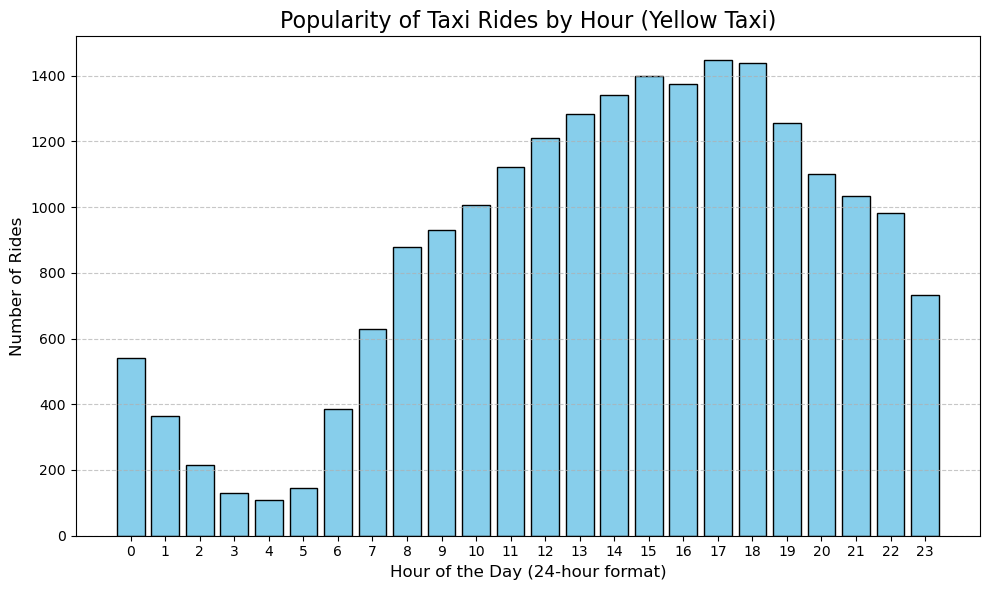

In [35]:
# Visulize 1
# SQLite Database Name
database_name = "project.db"
engine = create_engine(f"sqlite:///{database_name}")

def visualize_popular_taxi_hour():
    """
    Visualize the most popular hour to take a taxi.
    """
    # Query to get ride counts per hour
    query = """
    SELECT 
        strftime('%H', tpep_pickup_datetime) AS hour,
        COUNT(*) AS ride_count
    FROM yellow_taxi
    GROUP BY hour
    ORDER BY ride_count DESC;
    """
    
    # Execute the query and load data into a DataFrame
    with engine.connect() as connection:
        hourly_rides = pd.read_sql(query, connection)

    # Convert the hour column to an integer for sorting
    hourly_rides['hour'] = hourly_rides['hour'].astype(int)

    # Sort the data by hour for a sequential x-axis
    hourly_rides = hourly_rides.sort_values(by='hour')

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.bar(hourly_rides['hour'], hourly_rides['ride_count'], color='skyblue', edgecolor='black')
    plt.title("Popularity of Taxi Rides by Hour (Yellow Taxi)", fontsize=16)
    plt.xlabel("Hour of the Day (24-hour format)", fontsize=12)
    plt.ylabel("Number of Rides", fontsize=12)
    plt.xticks(range(0, 24))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Call the function to render the visualization
visualize_popular_taxi_hour()


### 4.2 Visualization 2: What’s the most popular month to hire a cab or Uber?

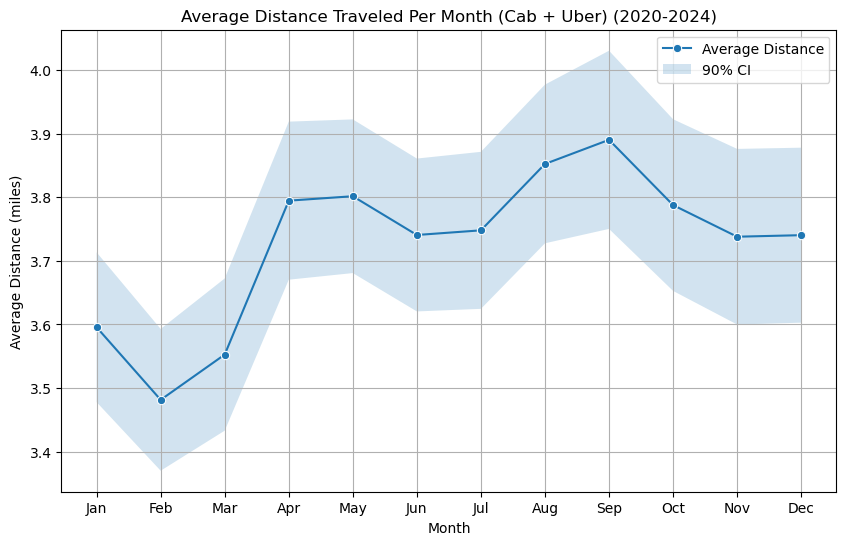

In [36]:
import seaborn as sns
from scipy.stats import t
# Connect to the database
conn = sqlite3.connect('project.db')  
cursor = conn.cursor()

# Load yellow_taxi data
yellow_taxi_query = """
SELECT 
    strftime('%m', tpep_pickup_datetime) as month,
    trip_distance
FROM yellow_taxi
"""
yellow_taxi = pd.read_sql_query(yellow_taxi_query, conn)

# Load hvfhv (Uber) data
hvfhv_query = """
SELECT 
    strftime('%m', pickup_datetime) as month,
    trip_miles
FROM hvfhv
"""
hvfhv = pd.read_sql_query(hvfhv_query, conn)
hvfhv.rename(columns={'trip_miles': 'trip_distance'}, inplace=True) #Rename to ensure combination

# Combine data
data = pd.concat([yellow_taxi, hvfhv], ignore_index=True)

# Group by month_only (to aggregate regardless of year)
grouped = data.groupby('month')['trip_distance'].agg(['mean', 'count', 'std']).reset_index()

# Calculate 90% confidence interval
confidence = 0.90
grouped['sem'] = grouped['std'] / grouped['count'] ** 0.5  # Standard error
h = grouped['sem'] * t.ppf((1 + confidence) / 2, grouped['count'] - 1)  # Margin of error
grouped['ci_lower'] = grouped['mean'] - h
grouped['ci_upper'] = grouped['mean'] + h

# Visualization
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped, x='month', y='mean', label='Average Distance', marker="o")
plt.fill_between(grouped['month'], grouped['ci_lower'], grouped['ci_upper'], alpha=0.2, label='90% CI')

# Customize plot
plt.title('Average Distance Traveled Per Month (Cab + Uber) (2020-2024)')
plt.xlabel('Month')
plt.ylabel('Average Distance (miles)')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True)

# Show plot
plt.show()

# Close the database connection
conn.close()

### 4.3 Visualization 3: Which day of the week is most popular for taking a ride to an NYC-based airport?

<Figure size 1000x600 with 0 Axes>

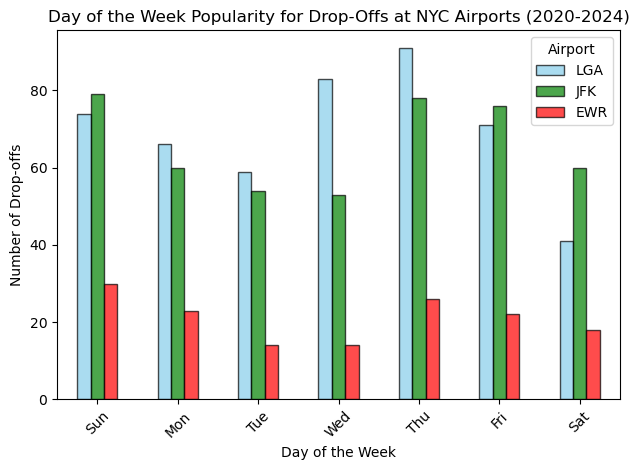

In [37]:
# Connect to SQLite database
conn = sqlite3.connect('project.db')

# Query to load yellow_taxi data (dropoff details)
yellow_taxi_query = """
SELECT 
    strftime('%Y-%m-%d', tpep_dropoff_datetime) AS dropoff_date,
    strftime('%w', tpep_dropoff_datetime) AS day_of_week,
    dropoff_latitude,
    dropoff_longitude
FROM yellow_taxi
"""
yellow_taxi = pd.read_sql_query(yellow_taxi_query, conn)

# Query to load hvfhv (Uber) data (dropoff details)
hvfhv_query = """
SELECT 
    strftime('%Y-%m-%d', dropoff_datetime) AS dropoff_date,
    strftime('%w', dropoff_datetime) AS day_of_week,
    dropoff_latitude,
    dropoff_longitude
FROM hvfhv
"""
hvfhv = pd.read_sql_query(hvfhv_query, conn)

# Define bounding boxes for the three airports
def is_within_bbox(lat, lon, bbox):
    lat_min, lat_max, lon_min, lon_max = bbox
    return lat_min <= lat <= lat_max and lon_min <= lon <= lon_max

# Bounding boxes for airports
lga_bbox = (40.7650, 40.7860, -73.8920, -73.8600)  # LGA
jfk_bbox = (40.6300, 40.6500, -73.8100, -73.7500)  # JFK
ewr_bbox = (40.6800, 40.7400, -74.2100, -74.1500)  # EWR

# Filter data for each airport based on coordinates
yellow_taxi_lga = yellow_taxi[yellow_taxi.apply(lambda row: is_within_bbox(row['dropoff_latitude'], row['dropoff_longitude'], lga_bbox), axis=1)]
yellow_taxi_jfk = yellow_taxi[yellow_taxi.apply(lambda row: is_within_bbox(row['dropoff_latitude'], row['dropoff_longitude'], jfk_bbox), axis=1)]
yellow_taxi_ewr = yellow_taxi[yellow_taxi.apply(lambda row: is_within_bbox(row['dropoff_latitude'], row['dropoff_longitude'], ewr_bbox), axis=1)]

hvfhv_lga = hvfhv[hvfhv.apply(lambda row: is_within_bbox(row['dropoff_latitude'], row['dropoff_longitude'], lga_bbox), axis=1)]
hvfhv_jfk = hvfhv[hvfhv.apply(lambda row: is_within_bbox(row['dropoff_latitude'], row['dropoff_longitude'], jfk_bbox), axis=1)]
hvfhv_ewr = hvfhv[hvfhv.apply(lambda row: is_within_bbox(row['dropoff_latitude'], row['dropoff_longitude'], ewr_bbox), axis=1)]

# Combine data from yellow_taxi and hvfhv for each airport
lga_data = pd.concat([yellow_taxi_lga, hvfhv_lga])
jfk_data = pd.concat([yellow_taxi_jfk, hvfhv_jfk])
ewr_data = pd.concat([yellow_taxi_ewr, hvfhv_ewr])

# Group by day of the week (0 = Sunday, 6 = Saturday) and count drop-offs
lga_day_of_week = lga_data.groupby('day_of_week').size()
jfk_day_of_week = jfk_data.groupby('day_of_week').size()
ewr_day_of_week = ewr_data.groupby('day_of_week').size()

# Prepare data for plotting
day_of_week_labels = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'Day of Week': day_of_week_labels,
    'LGA': lga_day_of_week.values,
    'JFK': jfk_day_of_week.values,
    'EWR': ewr_day_of_week.values
})

# Plot the data
plt.figure(figsize=(10, 6))
plot_data.set_index('Day of Week').plot(kind='bar', stacked=False, color=['skyblue', 'green', 'red'], alpha=0.7, edgecolor="black")
plt.title('Day of the Week Popularity for Drop-Offs at NYC Airports (2020-2024)')
plt.ylabel('Number of Drop-offs')
plt.xlabel('Day of the Week')
plt.xticks(rotation=45)
plt.legend(title='Airport', labels=['LGA', 'JFK', 'EWR'])
plt.tight_layout()
plt.show()


#### 4.4 Visualization 4: How much do hired rides earn in total fares monthly?


In [ ]:
# Load Yellow Taxi data (adjust query as per the database)
yellow_taxi_query = """
SELECT 
    strftime('%Y-%m', tpep_pickup_datetime) as month, 
    fare_amount, 
    mta_tax, 
    tolls_amount, 
    congestion_surcharge
FROM yellow_taxi
"""
yellow_taxi = pd.read_sql_query(yellow_taxi_query, conn)

# Calculate total fare and its components for Yellow Taxi
yellow_taxi['total_fare'] = (yellow_taxi['fare_amount'] + 
                             yellow_taxi['mta_tax'] + 
                             yellow_taxi['tolls_amount'] + 
                             yellow_taxi['congestion_surcharge'])

# Group by month and calculate the sum of each component
yellow_taxi_monthly = yellow_taxi.groupby('month').agg({
    'fare_amount': 'sum',
    'mta_tax': 'sum',
    'tolls_amount': 'sum',
    'congestion_surcharge': 'sum',
    'total_fare': 'sum'
}).reset_index()

# Load Uber data (adjust query as per the database)
hvfhv_query = """
SELECT 
    strftime('%Y-%m', pickup_datetime) as month, 
    base_passenger_fare, 
    tolls, 
    sales_tax, 
    congestion_surcharge
FROM hvfhv
"""
hvfhv = pd.read_sql_query(hvfhv_query, conn)

# Calculate total fare and its components for Uber
hvfhv['total_fare'] = (hvfhv['base_passenger_fare'] + 
                       hvfhv['tolls'] + 
                       hvfhv['sales_tax'] + 
                       hvfhv['congestion_surcharge'])

# Group by month and calculate the sum of each component for Uber
hvfhv_monthly = hvfhv.groupby('month').agg({
    'base_passenger_fare': 'sum',
    'tolls': 'sum',
    'sales_tax': 'sum',
    'congestion_surcharge': 'sum',
    'total_fare': 'sum'
}).reset_index()


In [ ]:
# Merge the data for Yellow Taxi and Uber
monthly_data = pd.merge(yellow_taxi_monthly, hvfhv_monthly, on='month', suffixes=('_yellow_taxi', '_uber'))
new_columns = ["month",	"base fare(yellow taxi)",	
               "taxes(yellow taxi)", "tolls(yellow taxi)", 
               "surcharge(yellow taxi)", "total fare(yellow taxi)",
               "base fare(uber)", "tolls(uber)", "taxex(uber)", 
                "surcharge(uber)", "total fare(uber)"]
monthly_data.columns = new_columns


In [ ]:
# Define a color palette for the different fare components
colors_yellow_taxi = ['#FFB5A7', '#FFE066', '#A0D6D1', '#B38DFF']
colors_uber = ['#FF6347', '#FFD700', '#20B2AA', '#8A2BE2'] 

# Set the plot size (increase width)
plt.figure(figsize=(18, 8))

# Plot for Yellow Taxi with specific colors for each fare component
monthly_data.set_index('month')[["base fare(yellow taxi)",	"taxes(yellow taxi)", "tolls(yellow taxi)", "surcharge(yellow taxi)"]].plot(
    kind='bar', stacked=True, width=0.4, position=1, label='Yellow Taxi', color=colors_yellow_taxi, ax=plt.gca())

# Plot for Uber with specific colors for each fare component
monthly_data.set_index('month')[["base fare(uber)", "tolls(uber)", "taxex(uber)", "surcharge(uber)"]].plot(
    kind='bar', stacked=True, width=0.4, position=0, label='Uber', color=colors_uber, ax=plt.gca())

# Set labels and title
plt.title('Monthly Earned Total Fares Comparison (Yellow Taxis vs Ubers)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Fare ($)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Fare Components', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()

#### 4.5 Visualization 5: Does precipitation or distance traveled affect the amount of tip?


In [ ]:
# Connect to SQLite database
conn = sqlite3.connect('project.db')

# Query for Yellow Taxi data (2022-2023)
yellow_taxi_query = """
SELECT tpep_pickup_datetime, trip_distance, tip_amount
FROM yellow_taxi
WHERE strftime('%Y', tpep_pickup_datetime) BETWEEN '2022' AND '2023'
"""
yellow_taxi_data = pd.read_sql_query(yellow_taxi_query, conn)

# Query for Uber data (2022-2023)
hvfhv_query = """
SELECT pickup_datetime, trip_miles, tips
FROM hvfhv
WHERE strftime('%Y', pickup_datetime) BETWEEN '2022' AND '2023'
"""
hvfhv_data = pd.read_sql_query(hvfhv_query, conn)

# Query for hourly weather data
weather_query = """
SELECT observation_date, hourly_precip_mm
FROM hourly_weather
WHERE strftime('%Y', observation_date) BETWEEN '2022' AND '2023'
"""
weather_data = pd.read_sql_query(weather_query, conn)

# Prepare the data for Yellow Taxi and Uber precipitation data
yellow_taxi_data['pickup_hour'] = pd.to_datetime(yellow_taxi_data['tpep_pickup_datetime']).dt.strftime('%Y-%m-%d %H')
hvfhv_data['pickup_hour'] = pd.to_datetime(hvfhv_data['pickup_datetime']).dt.strftime('%Y-%m-%d %H')
weather_data['observation_hour'] = pd.to_datetime(weather_data['observation_date']).dt.strftime('%Y-%m-%d %H')

# Merge Yellow Taxi with weather data based on hour
yellow_taxi_weather = pd.merge(yellow_taxi_data, weather_data[['observation_hour', 'hourly_precip_mm']], 
                               left_on='pickup_hour', right_on='observation_hour', how='left')

# Merge Uber with weather data based on hour
hvfhv_weather = pd.merge(hvfhv_data, weather_data[['observation_hour', 'hourly_precip_mm']], 
                         left_on='pickup_hour', right_on='observation_hour', how='left')

# Set up the plot with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Yellow Taxi tip vs distance
axs[0, 0].scatter(yellow_taxi_data['trip_distance'], yellow_taxi_data['tip_amount'], alpha=0.5, color='blue')
axs[0, 0].set_title('Yellow Taxi: Tip vs Distance')
axs[0, 0].set_xlabel('Distance (miles)')
axs[0, 0].set_ylabel('Tip Amount ($)')

# Plot 2: Uber tip vs distance
axs[0, 1].scatter(hvfhv_data['trip_miles'], hvfhv_data['tips'], alpha=0.5, color='green')
axs[0, 1].set_title('Uber: Tip vs Distance')
axs[0, 1].set_xlabel('Distance (miles)')
axs[0, 1].set_ylabel('Tip Amount ($)')

# Plot 3: Yellow Taxi tip vs precipitation
axs[1, 0].scatter(yellow_taxi_weather['hourly_precip_mm'], yellow_taxi_weather['tip_amount'], alpha=0.5, color='orange')
axs[1, 0].set_title('Yellow Taxi: Tip vs Precipitation')
axs[1, 0].set_xlabel('Precipitation (mm)')
axs[1, 0].set_ylabel('Tip Amount ($)')

# Plot 4: Uber tip vs precipitation
axs[1, 1].scatter(hvfhv_weather['hourly_precip_mm'], hvfhv_weather['tips'], alpha=0.5, color='red')
axs[1, 1].set_title('Uber: Tip vs Precipitation')
axs[1, 1].set_xlabel('Precipitation (mm)')
axs[1, 1].set_ylabel('Tip Amount ($)')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


#### 4.6 Visualization 6: Heatmap

In [ ]:
# Connect to SQLite database
conn = sqlite3.connect('project.db')

# Query to get dropoff data for Yellow Taxis in 2020
yellow_taxi_query = """
SELECT dropoff_latitude, dropoff_longitude
FROM yellow_taxi
WHERE strftime('%Y', tpep_dropoff_datetime) = '2020'
"""
yellow_taxi_data = pd.read_sql_query(yellow_taxi_query, conn)

# Query to get dropoff data for Uber (HVFHV) in 2020
hvfhv_query = """
SELECT dropoff_latitude, dropoff_longitude
FROM hvfhv
WHERE strftime('%Y', pickup_datetime) = '2020'
"""
hvfhv_data = pd.read_sql_query(hvfhv_query, conn)

# Combine data from both Yellow Taxis and Uber
combined_data = pd.concat([yellow_taxi_data, hvfhv_data], ignore_index=True)

# Create a base map using Folium, centered around New York City
m = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

# Prepare the data: convert latitude and longitude to a list of coordinates
heat_data = combined_data[['dropoff_latitude', 'dropoff_longitude']].dropna()  # Remove rows with missing values
heat_data = heat_data.values.tolist()  # Convert to a list of lists

# Add the heatmap layer to the map
HeatMap(heat_data).add_to(m)

# Save the map as an HTML file, which can be viewed in a browser
outputpath = r"D:\Columbia University\24 Fall\IEOR 4501\Final Project\heatmap_2020.html"
m.save(outputpath)